In [14]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import interp1d

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'd:\\projects\\github\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [15]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

In [16]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=30
)

cf2d = cf.CoreFlooding2D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=20, Nr = 5
)

xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

In [17]:
t_data, R_data, dp_data = cf_1d.simulate_no_pc()


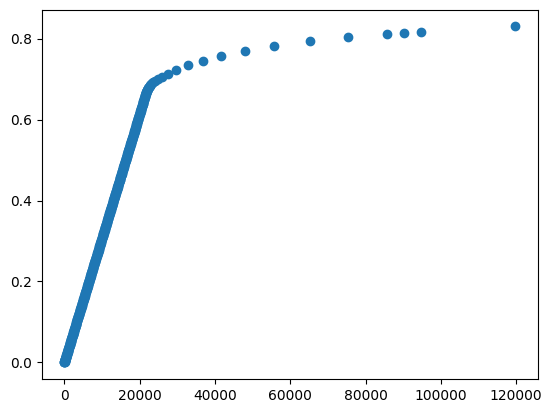

In [18]:
plt.plot(t_data, R_data, 'o')
cf_1d.numerical_params.simulation_time = 130000.0

## Fittin model to core flooding data

In [19]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters
def residual(params, t, R):
    cf_1d.rel_perm.kro0 = params['kro0']
    cf_1d.rel_perm.krw0 = params['krw0']
    cf_1d.rel_perm.nw = params['nw']
    cf_1d.rel_perm.no = params['no']
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num)(t)
    return (R_calc - R)


params = Parameters()
params.add('kro0', value=0.5, min=0.1, max=1.0)
params.add('krw0', value=0.2, min=0.05, max=0.6)
params.add('no', value=2.0, min=1.0, max=3.0)
params.add('nw', value=2.0, min=1.0, max=3.0)

out = minimize(residual, params, args=(t_data, R_data))

AttributeError: 'MinimizerResult' object has no attribute 'best_fit'

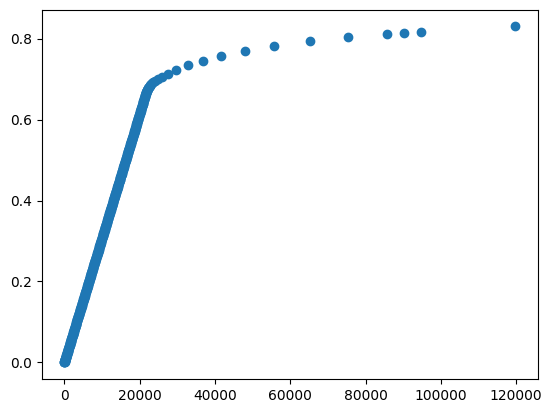

In [24]:
plt.plot(t_data, R_data, 'o')
plt.plot(t_data, out.best_fit, 'r-')

In [25]:
out.